In [33]:
import torch 
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import pandas as pd

In [2]:
class MyProblem():
    def __init__(self):
        super().__init__()
        self.F = [0]*3
        self.G = [0]*10
        
        self.f_capital = 0
        self.v_mbp= 0
        self.v_fd = 0
        
    def evaluate(self, x): 
        #x:variable(numpy array), out:output(dictionary). 
        #out["F"]: numpy array with n_obj length, objective values are written here.
        #out["G"]: numpy array with n_constr length, constraints values are written here. 
        
        self.f_capital = 4.72 - 0.5*x[3] - 0.19*x[1]*x[2]
        self.v_mbp = 10.58 - 0.674*x[0]*x[1] - 0.67275*x[1]
        self.v_fd = 16.45 - 0.489*x[2]*x[6] - 0.843*x[4]*x[5]
        
        self.F[0] = 1.98 + 4.9*x[0] + 6.67*x[1] + 6.98*x[2] + 4.01*x[3] + 1.78*x[4] + 0.000001*x[5] + 2.73*x[6]
        self.F[1] = self.f_capital
        self.F[2] = 0.5*(self.v_mbp + self.v_fd)
        
        #constraints: g must be zero or negative
        self.G[0] = 1.16 - 0.3717*x[1]*x[3] - 0.0092928*x[2] -1 
        self.G[1] = 0.261 - 0.0159*x[0]*x[1] - 0.06486*x[0] - 0.019*x[1]*x[6] + 0.0144*x[2]*x[4] \
            + 0.0154464*x[5] - 0.32
        self.G[2] = 0.214 + 0.00817*x[4] - 0.045195*x[0] - 0.0135168*x[0] \
            + 0.03099*x[1]*x[5] - 0.018*x[1]*x[6] + 0.007176*x[2] \
            + 0.023232*x[2] - 0.00364*x[4]*x[5] - 0.018*x[1]**2 - 0.32
        self.G[3] = 0.74 - 0.61*x[1] - 0.031296*x[2] - 0.031872*x[6] + 0.227*x[1]**2 - 0.32
        self.G[4] = 28.98 + 3.818*x[2] - 4.2*x[0]*x[1] + 1.27296*x[5] - 2.68065*x[6] - 32
        self.G[5] = 33.86 + 2.95*x[2] - 5.057*x[0]*x[1] - 3.795*x[1] - 3.4431*x[6] + 1.45728 - 32
        self.G[6] = 46.36 - 9.9*x[1] - 4.4505*x[0] -32
        self.G[7] = self.f_capital - 4
        self.G[8] = self.v_mbp -9.9
        self.G[9] = self.v_fd -15.7
        
    def calc_loss(self, w):
        #w:weight
        return w[0]*self.F[0] + w[1]*self.F[1]*10 + w[2]*self.F[2] #だいたいオーダーをそろえるために1000倍した

## Adamによる最適化

In [3]:
lower = np.array([0.5, 0.45, 0.5, 0.5, 0.875, 0.4, 0.4]) #lower bound
upper = np.array([1.5, 1.35, 1.5, 1.5, 2.625, 1.2, 1.2]) #upper bound

In [4]:
losses = []
#weights = [0.1, 0.2, 0.3, 0.4, 0.5]
F_s = []
x_es = []

w = [0.0,0.0,1.0]

for n in range(101):
    #loss_temp_n = []
    
    for m in range(101):
        
        problem = MyProblem()
        x = torch.ones(7, requires_grad=True)
        optimizer = optim.Adam([x])
        #loss_temp  =[n,m]
    
        for i in range(5000):
            optimizer.zero_grad()
            problem.evaluate(x)
            loss = problem.calc_loss(w)
            loss.backward()
            optimizer.step()
            #loss_temp.append(loss)

            with torch.no_grad(): #不等式制約
                for j in range(len(lower)):
                    x[j].clamp_(lower[j],upper[j])
        
        F_temp = [problem.F[0].to('cpu').detach().numpy().copy(),
                  problem.F[1].to('cpu').detach().numpy().copy(),
                  problem.F[2].to('cpu').detach().numpy().copy()]

        F_s.append(F_temp)
        #deflections.append(problem.G.to('cpu').detach().numpy().copy())
        #losses.append(loss_temp)
        x_es.append([n,m,x.to('cpu').detach().numpy()])
        
        print(n, m, w)
        
        if w[2]>0:
            w[0] = w[0] + 0.01
            w[2] = 1 - w[0] - w[1]
        else:
            break
        
    if (w[1]<1):
        w[0] = 0.0
        w[1] = w[1] + 0.01
        w[2] = 1 - w[0] - w[1]
    else:
        break

0 0 [0.0, 0.0, 1.0]
0 1 [0.01, 0.0, 0.99]
0 2 [0.02, 0.0, 0.98]
0 3 [0.03, 0.0, 0.97]
0 4 [0.04, 0.0, 0.96]
0 5 [0.05, 0.0, 0.95]
0 6 [0.060000000000000005, 0.0, 0.94]
0 7 [0.07, 0.0, 0.9299999999999999]
0 8 [0.08, 0.0, 0.92]
0 9 [0.09, 0.0, 0.91]
0 10 [0.09999999999999999, 0.0, 0.9]
0 11 [0.10999999999999999, 0.0, 0.89]
0 12 [0.11999999999999998, 0.0, 0.88]
0 13 [0.12999999999999998, 0.0, 0.87]
0 14 [0.13999999999999999, 0.0, 0.86]
0 15 [0.15, 0.0, 0.85]
0 16 [0.16, 0.0, 0.84]
0 17 [0.17, 0.0, 0.83]
0 18 [0.18000000000000002, 0.0, 0.82]
0 19 [0.19000000000000003, 0.0, 0.8099999999999999]
0 20 [0.20000000000000004, 0.0, 0.7999999999999999]
0 21 [0.21000000000000005, 0.0, 0.7899999999999999]
0 22 [0.22000000000000006, 0.0, 0.7799999999999999]
0 23 [0.23000000000000007, 0.0, 0.7699999999999999]
0 24 [0.24000000000000007, 0.0, 0.7599999999999999]
0 25 [0.25000000000000006, 0.0, 0.75]
0 26 [0.26000000000000006, 0.0, 0.74]
0 27 [0.2700000000000001, 0.0, 0.73]
0 28 [0.2800000000000001, 0.0, 

In [14]:
x_es[0]

[0,
 0,
 tensor([1.5000, 1.3500, 1.5000, 1.0000, 2.6250, 1.2000, 1.2000],
        requires_grad=True)]

In [13]:
Fs_np = np.array(F_s)
Fs_np.shape, x_np.shape

((5151, 3), (5151, 3))

In [51]:
np.save('09_Fs',Fs_np)

In [52]:
np.save('09_x_es',x_np)

In [56]:
Fs_np.shape

(5151, 3)

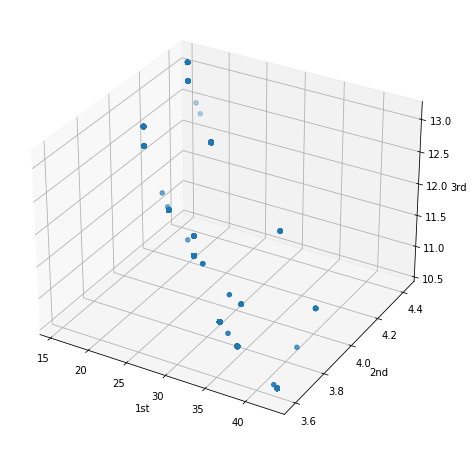

In [16]:
fig = plt.figure(figsize=(10,8))

ax = fig.add_subplot(projection='3d')
ax.scatter(Fs_np[:,0], Fs_np[:,1], Fs_np[:,2])
ax.set_xlabel("1st")
ax.set_ylabel("2nd")
ax.set_zlabel("3rd")
fig.show()

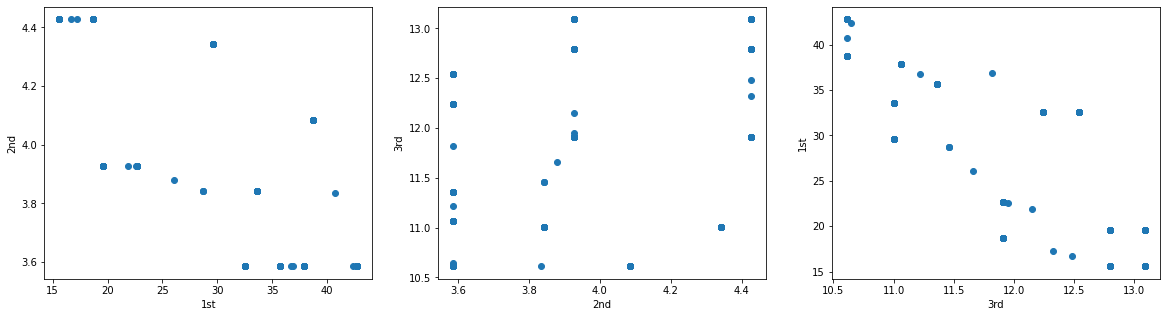

In [59]:
fig = plt.figure(figsize=(20,5))
ax1 = fig.add_subplot(1,3,1)
ax2 = fig.add_subplot(1,3,2)
ax3 = fig.add_subplot(1,3,3)

ax1.scatter(Fs_np[:,0],Fs_np[:,1])
ax1.set_xlabel("1st")
ax1.set_ylabel("2nd")
ax2.scatter(Fs_np[:,1],Fs_np[:,2])
ax2.set_xlabel("2nd")
ax2.set_ylabel("3rd")
ax3.scatter(Fs_np[:,2],Fs_np[:,0])
ax3.set_xlabel("3rd")
ax3.set_ylabel("1st")
fig.show()

In [27]:
x_list = []
for i in range(len(x_np)):
    x_list.append(x_np[i,2].detach().numpy())
x_list

[array([1.5  , 1.35 , 1.5  , 1.   , 2.625, 1.2  , 1.2  ], dtype=float32),
 array([1.5  , 1.35 , 1.5  , 0.5  , 2.625, 1.2  , 1.2  ], dtype=float32),
 array([1.5  , 1.35 , 1.5  , 0.5  , 2.625, 1.2  , 1.2  ], dtype=float32),
 array([1.5  , 1.35 , 1.5  , 0.5  , 2.625, 1.2  , 1.2  ], dtype=float32),
 array([1.5  , 1.35 , 1.5  , 0.5  , 2.625, 1.2  , 1.2  ], dtype=float32),
 array([1.5  , 1.35 , 0.5  , 0.5  , 2.625, 1.2  , 0.4  ], dtype=float32),
 array([1.5  , 1.35 , 0.5  , 0.5  , 2.625, 1.2  , 0.4  ], dtype=float32),
 array([1.5  , 1.35 , 0.5  , 0.5  , 2.625, 1.2  , 0.4  ], dtype=float32),
 array([1.5  , 1.35 , 0.5  , 0.5  , 2.625, 1.2  , 0.4  ], dtype=float32),
 array([0.5  , 0.45 , 0.5  , 0.5  , 2.625, 1.2  , 0.4  ], dtype=float32),
 array([0.5  , 0.45 , 0.5  , 0.5  , 2.625, 1.2  , 0.4  ], dtype=float32),
 array([0.5  , 0.45 , 0.5  , 0.5  , 2.625, 1.2  , 0.4  ], dtype=float32),
 array([0.5  , 0.45 , 0.5  , 0.5  , 2.625, 1.2  , 0.4  ], dtype=float32),
 array([0.5  , 0.45 , 0.5  , 0.5  , 2.

In [37]:
df = pd.DataFrame(x_list)
df.columns=["x_0","x_1","x_2","x_3","x_4","x_5","x_6"]
df

,x_0,x_1,x_2,x_3,x_4,x_5,x_6
0,1.5,1.35,1.5,1.0,2.625,1.2,1.2
1,1.5,1.35,1.5,0.5,2.625,1.2,1.2
2,1.5,1.35,1.5,0.5,2.625,1.2,1.2
3,1.5,1.35,1.5,0.5,2.625,1.2,1.2
4,1.5,1.35,1.5,0.5,2.625,1.2,1.2
...,...,...,...,...,...,...,...
5146,0.5,1.35,1.5,1.5,0.875,1.2,0.4
5147,0.5,1.35,1.5,1.5,0.875,0.4,0.4
5148,1.5,1.35,1.5,1.5,2.625,1.2,1.2
5149,0.5,1.35,1.5,1.5,0.875,0.4,0.4


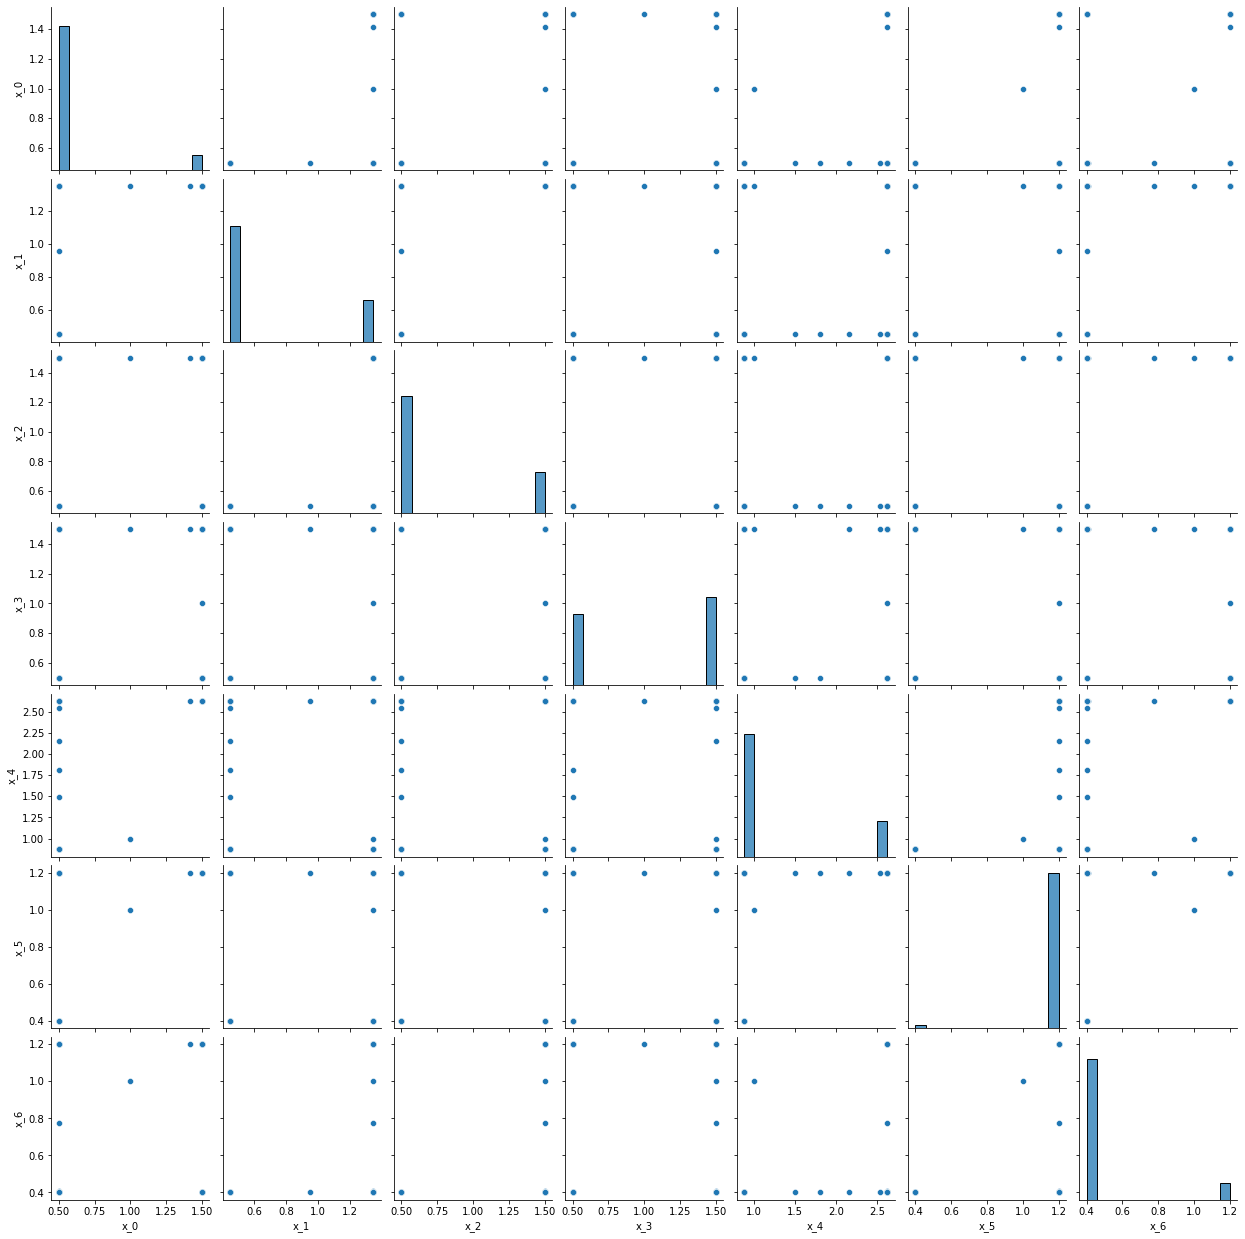

In [50]:
figure = sns.pairplot(df)
figure.savefig("09_pairolot")